In [1]:
"""
Configs:
    # Env
    env_id="NNWorld01-v01", 
     - once in the goal state, each action ends the episode and returns a reward of 5
     - no clear episodes, continuously train the agent with num_train_steps, 
       if the agent reaches terminal, just reset environment and keep training 
     - try to immitate the bandit experiments
    # Params
    eps_sched_fn=poly(0.5), lr_sched_fn=poly(0.8)
    # Algos
    haver2, action_sigma=adaptive(1), haver_delta=0.01, haver_const=varied
Status:
"""

from collections import defaultdict
import random
import numpy as np
np.set_printoptions(precision=5, suppress=True)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
sns.set_palette("tab20")
colors = sns.color_palette("bright")

import time
from tqdm import tqdm 
import multiprocessing

# import gymnasium as gym
import gym
import gym_examples
from gym.wrappers import FlattenObservation

from algos import *
from bandit_problem import *
from utils import *

In [2]:

random.seed(123)
np.random.seed(123)
tdqm_disable = True

# params
num_trials = 1
num_steps_train = 5000
num_episodes_eval = 100

lr_sched_type = "linear"
lr_sched_fn = create_lr_sched_fn(lr_sched_type, lr=0.7)

max_eps = 1.0
min_eps = 1.0
decay_rate = 0.0001
eps_sched_type = "poly"
eps_sched_fn = create_eps_sched_fn(eps_sched_type, min_eps, max_eps, decay_rate)

# create gym env
env_id = "gym_examples/NNWorldEnv01-v1"
env_scheme = "two_island"
gamma = 0.95

num_depths = 4
num_widths = 16
num_actions = num_widths
terminal_reward = -10.0

reward_dist = "normal"
problem_instance = "multi_gap_nonlinear"
action_max_mu = 0.0
action_sigma = 1.0
action_sigmas = action_sigma*np.ones(num_actions)
gap_splits = [0.5]
gap_deltas = [5.0]
bandit_problem = BanditProblem(
    problem_instance, reward_dist, num_actions, action_max_mu, 
    action_sigmas=action_sigmas, gap_splits=gap_splits, gap_deltas=gap_deltas)
print(f"action_mus = {bandit_problem.action_mus}")
print(f"action_sigmas = {bandit_problem.action_sigmas}")

action_max_mu = bandit_problem.action_mus[0]
optimal_num_steps = num_depths
optimal_vstar = terminal_reward*gamma**(optimal_num_steps-1) \
    + action_max_mu*np.sum([gamma**k for k in range(optimal_num_steps-1)])
optimal_reward_per_step = (terminal_reward + action_max_mu*(optimal_num_steps-1))/optimal_num_steps  
print(f"optimal_num_steps = {optimal_num_steps}")
print(f"optimal_reward_per_step = {optimal_reward_per_step}")
print(f"optimal_vstar = {optimal_vstar}")

env = gym.make(env_id, num_depths=num_depths, num_widths=num_widths, 
               bandit_problem=bandit_problem, terminal_reward=terminal_reward)
env_wrapped = FlattenObservation(env)
cur_state, info = env_wrapped.reset()

manager = multiprocessing.Manager()
episode_start_sigmahats_list = manager.list()
episode_rewards_list = manager.list()
episode_vstar_est_list = manager.list()
Q_table_list = manager.list()
Q_nvisits_list = manager.list()    

def run_trial(i_trial, args):

    random.seed(10000+i_trial)
    np.random.seed(10000+i_trial)

    # env = gym.make(env_id, size=gridworld_size)
    # env_wrapped = FlattenObservation(env)
    # env_wrapped.reset(seed=10000+i_trial)

    # lr_sched_fn = create_lr_sched_fn(lr_sched_type)
    # eps_sched_fn = create_eps_sched_fn(eps_sched_type, min_eps, max_eps, decay_rate)
    q_algo = create_q_algo(args["est_name"])

    Q_table, Q_nvisits, stats = q_algo(
        env_wrapped, num_actions, num_steps_train,
        gamma, lr_sched_fn, eps_sched_fn, tdqm_disable, args)

    episode_start_sigmahats, episode_rewards, episode_vstar_est= zip(*stats)
    episode_start_sigmahats_list.append(episode_start_sigmahats)
    episode_rewards_list.append(episode_rewards)
    episode_vstar_est_list.append(episode_vstar_est)
    Q_table_list.append(Q_table)
    Q_nvisits_list.append(Q_nvisits)

args = dict()
args["action_sigma"] = action_sigma
args["haver_alpha"] = 2.0
args["haver_delta"] = 0.05
args["haver_const"] = 1.0
args["weightedms_num_data"] = 1000
args["num_depths"] = num_depths
args["env_scheme"] = env_scheme

pool = multiprocessing.Pool()

episode_start_sigmahats_dict = defaultdict()
episode_rewards_dict = defaultdict()
episode_vstar_est_dict = defaultdict()
episode_vstar_est_bias_dict = defaultdict()
episode_vstar_est_var_dict = defaultdict()
episode_vstar_est_mse_dict = defaultdict()
Q_table_dict = defaultdict()
Q_nvisits_dict = defaultdict()

haver_const_ary = [1.0]
haver_name_ary = [f"haver_{x}" for x in haver_const_ary]
haver3_name_ary = [f"haver3_{x}" for x in haver_const_ary]

est_name_ary = ["max", "weightedms"]
# est_name_ary = haver_name_ary + est_name_ary 
# est_name_ary = est_name_ary + haver_name_ary
est_name_ary = est_name_ary + haver3_name_ary
est_name_ary = ["haver3_1.0", "weightedms"]
for est_name in est_name_ary:
    start_time = time.time()
    print(f"\n-> est_name = {est_name}")
    if "haver" in est_name:
        elems = est_name.split("_")
        args["est_name"] = elems[0]
        args["haver_const"] = float(elems[-1])
        print(f"haver_const = {args['haver_const']}")
    else:
        args["est_name"] = est_name
    
    pool.starmap(run_trial, [(i, args) for i in range(num_trials)])

    episode_start_sigmahats_ary = np.hstack([episode_start_sigmahats_list])
    episode_rewards_ary = np.hstack([episode_rewards_list])
    episode_vstar_est_ary = np.hstack([episode_vstar_est_list])

    episode_start_sigmahats_dict[est_name] = np.mean(episode_start_sigmahats_ary, 0)
    episode_rewards_dict[est_name] = np.mean(episode_rewards_ary, 0)
    episode_vstar_est_dict[est_name] = np.mean(episode_vstar_est_ary, 0)
    print(f"last_episode_start_sigmahat = {episode_start_sigmahats_dict[est_name][-1]:.4f}")
    print(f"last_episode_reward_per_step = {episode_rewards_dict[est_name][-1]:.4f}")
    print(f"last_episode_estim_start_muhat = {episode_vstar_est_dict[est_name][-1]:.4f}")
    
    episode_vstar_est_bias_dict[est_name] = np.mean(episode_vstar_est_ary - optimal_vstar, 0)
    episode_vstar_est_var_dict[est_name] = np.var(episode_vstar_est_ary - optimal_vstar, 0, ddof=1)
    episode_vstar_est_mse_dict[est_name] = \
        episode_vstar_est_bias_dict[est_name]**2 \
        + episode_vstar_est_var_dict[est_name]
    
    # Q_table_dict[est_name] = np.mean(np.stack(Q_table_list), 0)
    # Q_nvisits_dict[est_name] = np.mean(np.stack(Q_nvisits_list), 0)
    # print(np.stack(Q_table_list).shape)
    Q_table_dict[est_name] = np.stack(Q_table_list)[0,:,:,:]
    Q_nvisits_dict[est_name] = np.stack(Q_nvisits_list)[0,:,:,:]
    # print(Q_table_list[0][0,0,:])
    # print(Q_table_list[1][0,0,:])
    # print(Q_table_ary)
    # stop
                           
    episode_start_sigmahats_list[:] = []
    episode_rewards_list[:] = []
    episode_vstar_est_list[:] = []
    Q_table_list[:] = []
    Q_nvisits_list[:] = []
    
    end_time = time.time()
    print(f"it takes {end_time-start_time:0.4f}")

action_mus = [ 0.  0.  0.  0.  0.  0.  0.  0. -5. -5. -5. -5. -5. -5. -5. -5.]
action_sigmas = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
optimal_num_steps = 4
optimal_reward_per_step = -2.5
optimal_vstar = -8.573749999999999

-> est_name = haver3_1.0
haver_const = 1.0

-> i_step = 4960
cur_state = [0 0]
action = 1
reward = 0.82
new_state = [1 1]
haver3_estimator
[ 30.  90.  11. 122.  12. 220.  11.  10.]
[ 30.  90.  11. 122.  12. 220.  11.  10.]
[-8.23001 -8.31988 -8.39481 -8.32434 -8.46294 -8.32325 -8.8567  -8.37328]
[1.77701 2.24964 2.81948 2.03742 2.51945 2.13654 0.94548 2.61624]
haver3_estimator
action_maxlcb_idx = 5
action_maxlcb_muhat = -8.32
Bset_idxes = [0, 1, 2, 3, 4, 5, 6, 7]
Bset_probs = [0.05929 0.17787 0.02174 0.24111 0.02372 0.43478 0.02174 0.01976]
Bset_nvisits = [ 30.  90.  11. 122.  12. 220.  11.  10.]
Q_est = -8.33
weightedms_estimator
idxes = [0 1 2 3 4 5 6 7]
probs = [0.095 0.152 0.193 0.097 0.182 0.105 0.012 0.164]
Q_est = -8.37
Q_nvisits[cur_state][action] 

/home/tnn/miniconda3/envs/tnn1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/tnn/miniconda3/envs/tnn1/lib/python3.7/site-packages/numpy/core/_methods.py:252: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


last_episode_start_sigmahat = 1250.0000
last_episode_reward_per_step = -10.0000
last_episode_estim_start_muhat = -7.0276
it takes 3.5254


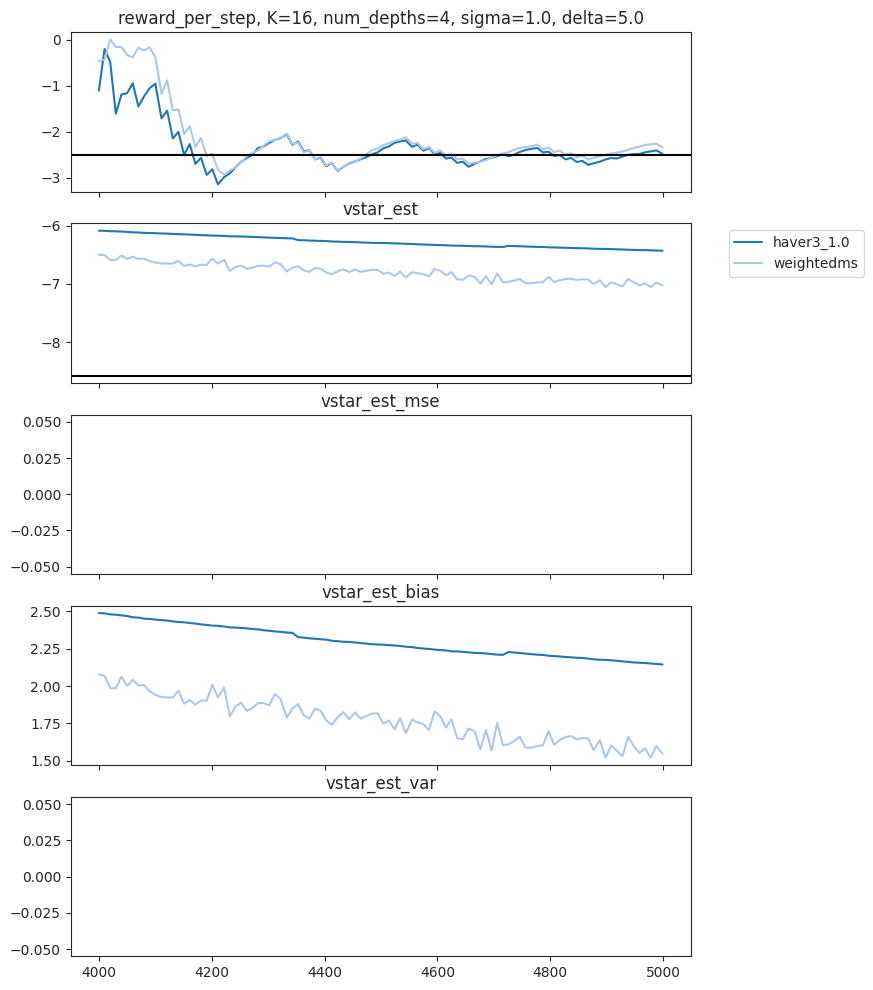

In [3]:

fig, axes = fig, axes = plt.subplots(
        nrows=5, ncols=1, sharex=True, sharey=False, figsize=(8,12))
# axes = [axes]

x_ary = np.linspace(4000, num_steps_train-1, num=100, dtype=np.int32)
# est_name_ary = ["weightedms"]
est_name_ary_unwanted = []
est_name_ary_wanted = [est_name for est_name in est_name_ary[:8] \
                 if est_name not in est_name_ary_unwanted]
for est_name in est_name_ary_wanted:
    # axes[0].plot(x_ary, episode_rewards_dict[est_name][x_ary], label=est_name)
    y_ary = running_avg(episode_rewards_dict[est_name][x_ary], 100)
    axes[0].plot(
        x_ary, y_ary, label=est_name)
    axes[1].plot(x_ary, episode_vstar_est_dict[est_name][x_ary], label=est_name)
    axes[2].plot(x_ary, episode_vstar_est_mse_dict[est_name][x_ary], label=est_name)
    axes[3].plot(x_ary, episode_vstar_est_bias_dict[est_name][x_ary], label=est_name)
    axes[4].plot(x_ary, episode_vstar_est_var_dict[est_name][x_ary], label=est_name)

axes[0].axhline(y=optimal_reward_per_step, color="black")
axes[1].axhline(y=optimal_vstar, color="black")
axes[0].set_title(f"reward_per_step, K={num_actions}, num_depths={num_depths}, sigma={action_sigma},"
                    f" delta={gap_deltas[0]}")
axes[1].set_title("vstar_est")
axes[2].set_title("vstar_est_mse")
axes[3].set_title("vstar_est_bias")
axes[4].set_title("vstar_est_var")
# axes[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axes[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# axes[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

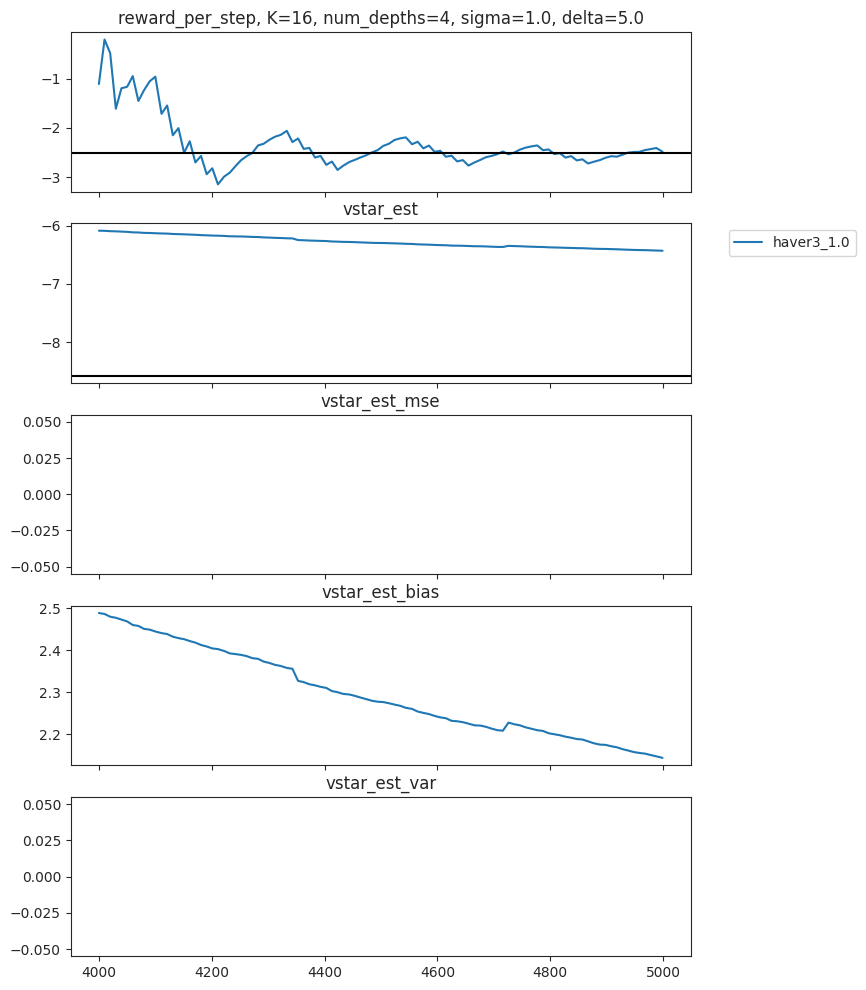

In [4]:

fig, axes = fig, axes = plt.subplots(
        nrows=5, ncols=1, sharex=True, sharey=False, figsize=(8,12))
# axes = [axes]

x_ary = np.linspace(4000, num_steps_train-1, num=100, dtype=np.int32)
# est_name_ary = ["weightedms"]
est_name_ary_unwanted = ["weightedms", "weightedms2"]
est_name_ary_wanted = [est_name for est_name in est_name_ary[:8] \
                 if est_name not in est_name_ary_unwanted]
for est_name in est_name_ary_wanted:
    # axes[0].plot(x_ary, episode_rewards_dict[est_name][x_ary], label=est_name)
    y_ary = running_avg(episode_rewards_dict[est_name][x_ary], 100)
    axes[0].plot(
        x_ary, y_ary, label=est_name)
    axes[1].plot(x_ary, episode_vstar_est_dict[est_name][x_ary], label=est_name)
    axes[2].plot(x_ary, episode_vstar_est_mse_dict[est_name][x_ary], label=est_name)
    axes[3].plot(x_ary, episode_vstar_est_bias_dict[est_name][x_ary], label=est_name)
    axes[4].plot(x_ary, episode_vstar_est_var_dict[est_name][x_ary], label=est_name)

axes[0].axhline(y=optimal_reward_per_step, color="black")
axes[1].axhline(y=optimal_vstar, color="black")
axes[0].set_title(f"reward_per_step, K={num_actions}, num_depths={num_depths}, sigma={action_sigma},"
                    f" delta={gap_deltas[0]}")
axes[1].set_title("vstar_est")
axes[2].set_title("vstar_est_mse")
axes[3].set_title("vstar_est_bias")
axes[4].set_title("vstar_est_var")
# axes[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axes[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# axes[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [5]:

for est_name in est_name_ary:
    print(f"\n-> est_name = {est_name}")
    Q_table = Q_table_dict[est_name]
    Q_nvisits = Q_nvisits_dict[est_name]
    for i_row in range(num_depths):
        for j_col in range(num_actions):
            print(f"{i_row} {j_col}: {Q_table[i_row,j_col]}, \n     {Q_nvisits[i_row,j_col]}")

 


-> est_name = haver3_1.0
0 0: [ -6.36655  -6.37005  -6.36995  -7.03459  -6.38522  -6.36938  -6.36566
  -6.39769 -10.0203   -8.74511 -10.03712 -12.57125  -9.8342   -7.91707
 -12.59392  -8.7192 ], 
     [103. 513.  79.   5. 112. 236. 100.  61.   5.   4.   4.   7.   8.   3.
   5.   5.]
0 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 2: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 3: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 4: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 5: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 6: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 7: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0